# Convulation Neural Network - Pytorch

## Possible Improvements

- higher image resolution
- larger kernel sizes
- more conovultional layers
- data augmentation

## Imports

In [1]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import PIL
import torch
from torch import nn
import numpy as np
import os 
import random

## Data Parameters

In [2]:
DATA_PATH = 'clean'
DATA_PATH_X = 'clean/x-data'
DATA_PATH_Y = 'clean/y-data'
CODES_PATH = "clean/codes.txt"
BATCH_SIZE = 32
IMG_SIZE = (128)
VALID_PER = 0.8
SEED = 42

## Custom Dateset and Dataloader

In [3]:
import os
from torchvision.io import read_image

class CustomImageDataset(Dataset):
    def __init__(self, img_dir, label_dir, transform=None):
        self.label_dir = label_dir
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(os.listdir(self.img_dir))

    def __getitem__(self, idx):
        name = f"{idx}.png"
        img_path = os.path.join(self.img_dir, os.listdir(self.img_dir)[idx])
        label_path = os.path.join(self.label_dir, os.listdir(self.label_dir)[idx])
        image = read_image(img_path)
        label = read_image(label_path)
        if self.transform:
            image, label = self.transform(image, label)
        return image, label

In [4]:
class MyTransform:
    def __init__(self, img_size):
        self.img_size = (img_size, img_size)

    def __call__(self, img, lbl):
        rotage_angle = int(random.random()*180)
        flip_bool = True if random.random() > 0.5 else False
        img = self.transform(img, rotage_angle, flip_bool)
        lbl = self.transform(lbl, rotage_angle, flip_bool)
        return img, lbl

    def transform(self, x, rotage_angle, flip_bool):
        resized_img = transforms.Resize(size=self.img_size)(x)
        pil_img =transforms.ToPILImage()(resized_img)
        gray_img = transforms.functional.to_grayscale(pil_img, num_output_channels=1)
        rotated_img = transforms.functional.rotate(gray_img, rotage_angle)
        if flip_bool:
            fliped_img = transforms.functional.vflip(rotated_img)
            return transforms.ToTensor()(fliped_img) 
        else:
            return transforms.ToTensor()(rotated_img)

In [5]:
def split_calculator(data, valid_per):
    number_of_file = len(os.listdir(data))
    split_length = [valid_per*number_of_file, (1-valid_per)*number_of_file]
    return [round(split_length[0]), round(split_length[1])]

In [6]:
dset = CustomImageDataset(DATA_PATH_X, DATA_PATH_Y, transform=MyTransform(IMG_SIZE))

In [7]:
split_length = split_calculator(DATA_PATH_X, VALID_PER)
training_dset, validation_dset = torch.utils.data.random_split(dset, split_length, generator=torch.Generator().manual_seed(SEED))

In [8]:
training_dls = torch.utils.data.DataLoader(training_dset, batch_size=BATCH_SIZE, shuffle=True)
validation_dls = torch.utils.data.DataLoader(validation_dset, batch_size=BATCH_SIZE)

In [9]:
def status_logger(dls):
    for X, y in dls:
        print(f"Shape of X [N, C, H, W]: {X.shape}")
        print(f"Shape of y: {y.shape} {y.dtype}")
        break

In [10]:
status_logger(training_dls)
status_logger(validation_dls)

Shape of X [N, C, H, W]: torch.Size([32, 1, 128, 128])
Shape of y: torch.Size([32, 1, 128, 128]) torch.float32
Shape of X [N, C, H, W]: torch.Size([32, 1, 128, 128])
Shape of y: torch.Size([32, 1, 128, 128]) torch.float32


## Model

### Model parameters

In [11]:
epochs = 10

### Model Structure

In [12]:
class LSNet(torch.nn.Module):
    def __init__(self):
        # call the parent constructor
        super(LSNet, self).__init__()
        self.conv_part = torch.nn.Sequential(
            torch.nn.Conv2d(1, 16, kernel_size=7, stride=4, padding=2),
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=3, stride=2),
            torch.nn.Conv2d(16, 32, kernel_size=5, padding=2),
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=3, stride=2),
            torch.nn.Conv2d(32, 64, kernel_size=3, padding=1),
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=3, stride=2)
        )
        self.deconv_part = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(64, 32, kernel_size=7, stride=4, padding=2),
            torch.nn.ReLU(inplace=True),
            torch.nn.Upsample(scale_factor=2, mode='bilinear'),
            torch.nn.ConvTranspose2d(32, 16, kernel_size=5, padding=2),
            torch.nn.ReLU(inplace=True),
            torch.nn.Upsample(scale_factor=2, mode='bilinear'),
            torch.nn.ConvTranspose2d(16, 1, kernel_size=3, padding=1),
            torch.nn.ReLU(inplace=True),
            torch.nn.Upsample(size=IMG_SIZE, mode='bilinear'),
        )
    def forward(self, x):
        x = self.conv_part(x)
        x = self.deconv_part(x)
        return x

In [13]:
model = LSNet()

In [14]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [15]:
input_test = torch.rand(20, 1, IMG_SIZE, IMG_SIZE)
print(input_test.shape)
model(input_test).shape

torch.Size([20, 1, 128, 128])


torch.Size([20, 1, 128, 128])

In [16]:
print(f"Model structure: {model}\n\n")

for name, param in model.named_parameters():
    print(f"Layer: {name} | Size: {param.size()} | Values : {param[:2]} \n")

Model structure: LSNet(
  (conv_part): Sequential(
    (0): Conv2d(1, 16, kernel_size=(7, 7), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (deconv_part): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(7, 7), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): Upsample(scale_factor=2.0, mode=bilinear)
    (3): ConvTranspose2d(32, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): Upsample(scale_factor=2.0, mode=bilinear)
    (6): ConvTranspose2d(16, 1

### Training and Testing functions

In [20]:
def train(dataloader, model, loss_fn, optimizer):
    r_loss = 0
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 20 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
        
        r_loss = loss
    return r_loss

In [21]:
def test(dataloader, model, loss_fn):
    losses = []
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            # X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Avg loss: {test_loss:>8f} \n")
    return test_loss
    

### Training

In [22]:
train_losses, test_losses = [], []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    tr_loss = train(training_dls, model, loss_fn, optimizer)
    te_loss = test(validation_dls, model, loss_fn)
    train_losses.append(tr_loss)
    test_losses.append(te_loss)
print("Done!")

Epoch 1
-------------------------------
loss: 0.265435  [    0/  686]
loss: 0.082326  [  640/  686]
Test Error: 
 Accuracy: 5770690.7%, Avg loss: 0.088168 

Epoch 2
-------------------------------
loss: 0.082905  [    0/  686]
loss: 0.080262  [  640/  686]
Test Error: 
 Accuracy: 5853902.3%, Avg loss: 0.078215 

Epoch 3
-------------------------------
loss: 0.078179  [    0/  686]
loss: 0.069018  [  640/  686]
Test Error: 
 Accuracy: 5783767.4%, Avg loss: 0.072665 

Epoch 4
-------------------------------
loss: 0.062609  [    0/  686]
loss: 0.067060  [  640/  686]
Test Error: 
 Accuracy: 5937230.2%, Avg loss: 0.069869 

Epoch 5
-------------------------------
loss: 0.064508  [    0/  686]
loss: 0.075041  [  640/  686]
Test Error: 
 Accuracy: 6179646.5%, Avg loss: 0.065640 

Epoch 6
-------------------------------
loss: 0.073584  [    0/  686]
loss: 0.058108  [  640/  686]
Test Error: 
 Accuracy: 5647807.0%, Avg loss: 0.062553 

Epoch 7
-------------------------------
loss: 0.070637  [ 

In [30]:
n_train_losses = []
for loss in train_losses:
    n_train_losses.append(loss.item())
n_train_losses

[0.11340802162885666,
 0.08218322694301605,
 0.06333305686712265,
 0.07513906061649323,
 0.06861855834722519,
 0.05455680564045906,
 0.07060877978801727,
 0.06250763684511185,
 0.05665542557835579,
 0.04115590825676918]

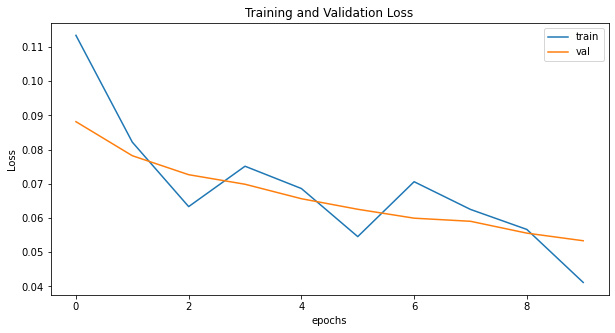

In [33]:
plt.figure(figsize=(10,5))
plt.title("Training and Validation Loss")
plt.plot(n_train_losses,label="train")
plt.plot(test_losses,label="val")
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

### Model postprocessing and evaluation

In [35]:
torch.save(model.state_dict(), "models/main/model_2022_08_02_14_23.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


In [36]:
model.eval()
x, y = dset[20][0], dset[20][1]
print(x.shape)
print(y.shape)
with torch.no_grad():
    pred = model(x[None,:])


torch.Size([1, 128, 128])
torch.Size([1, 128, 128])


In [37]:
new_pred = pred[0]
new_pred.shape

torch.Size([1, 128, 128])

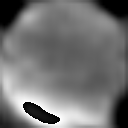

In [38]:
transforms.ToPILImage()(new_pred)

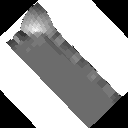

In [39]:
transforms.ToPILImage()(y)